In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch


In [5]:
offensive_data = pd.read_csv("/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv")
offensive_data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


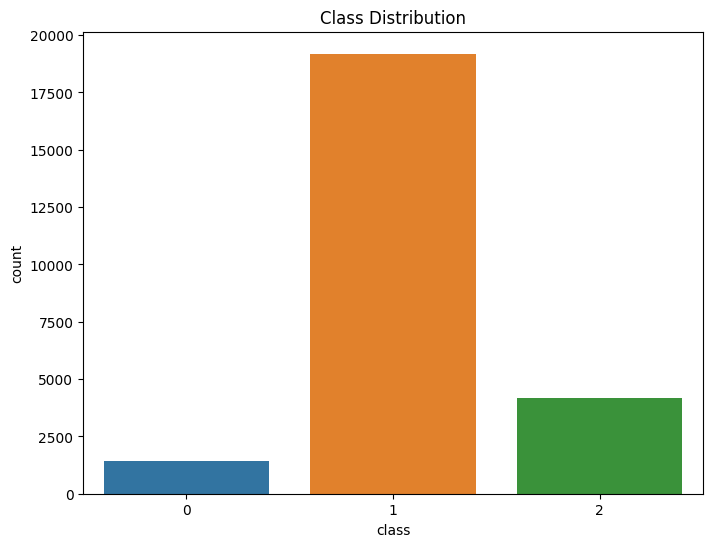

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(offensive_data, x="class")
plt.title("Class Distribution")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

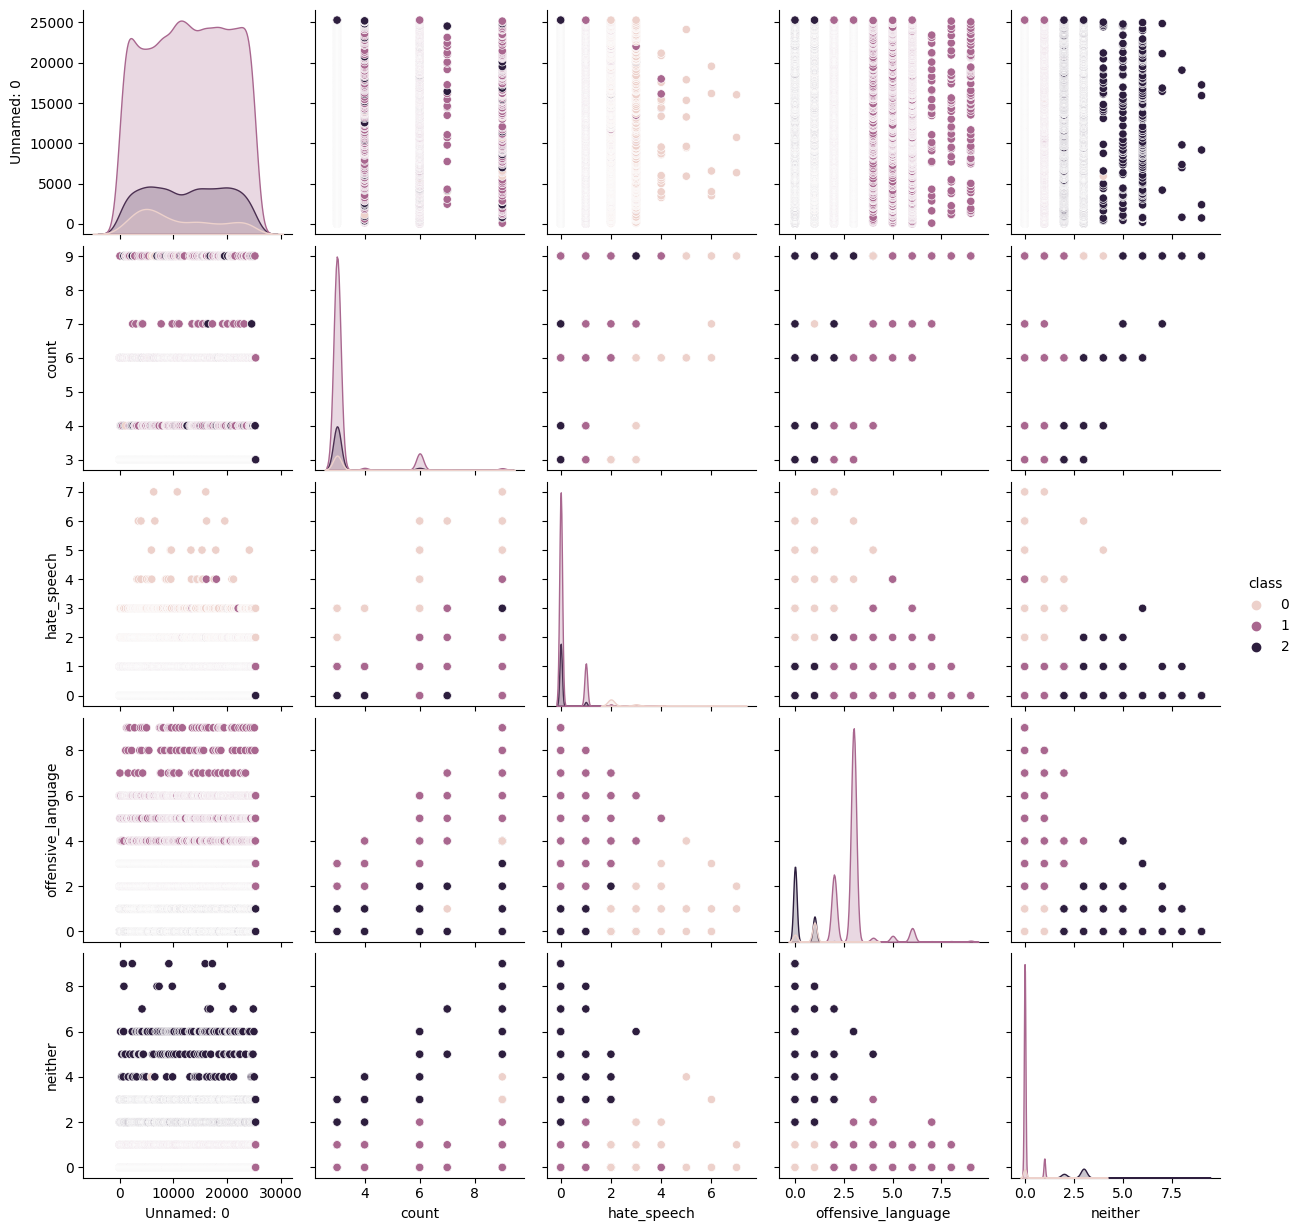

In [7]:
sns.pairplot(offensive_data, hue="class")
plt.show()

In [8]:
def clean_text(text):
    # Remove retweet markers with one or more '!' (e.g., "! RT @username:" or "!!! RT @username:")
    text = re.sub(r'!+ RT @\w+:', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Strip leading and trailing whitespace after cleanup
    return text.strip()



In [9]:
offensive_data['cleaned_tweet'] = offensive_data['tweet'].apply(clean_text)

In [10]:
offensive_data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,cleaned_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,As a woman you shouldn't complain about cleani...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats cold...tyga dwn bad for cuffin dat ho...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT @UrKindOfBrand Dawg You ever fuck a...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,@viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,The shit you hear about me might be true or it...
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...","you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies


In [11]:
def change_label(nb):
    return max(1, nb)

In [12]:
offensive_data['class'] = offensive_data['class'].apply(change_label)

In [13]:
!pip install imbalanced-learn

In [14]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd

# Separate features and target variable
X = offensive_data['cleaned_tweet'].values.reshape(-1, 1)  # Convert text to 2D array if using single feature
y = offensive_data['class']

# Option 1: Oversample the minority class
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Option 2: Undersample the majority class
# undersampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Combine resampled data back into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['text'])
df_resampled['class'] = y_resampled

# Display new class distribution
print("Resampled class distribution:", Counter(df_resampled['class']))
print(df_resampled)


Resampled class distribution: Counter({2: 20620, 1: 20620})
                                                    text  class
0      As a woman you shouldn't complain about cleani...      2
1      boy dats cold...tyga dwn bad for cuffin dat ho...      1
2      !!!!!!! RT @UrKindOfBrand Dawg You ever fuck a...      1
3                     @viva_based she look like a tranny      1
4      The shit you hear about me might be true or it...      1
...                                                  ...    ...
41235  @Kummar_King I volunteer to be guinea pig and ...      2
41236  @b1gsean21 lets just say hellen keller makes b...      2
41237  @contrarian11 @YouTube yeah. great song. just ...      2
41238  RT @PolitiBunny: #YesWeDid attack, harass, thr...      2
41239  Have you ever popped champagne on a plane, whi...      2

[41240 rows x 2 columns]


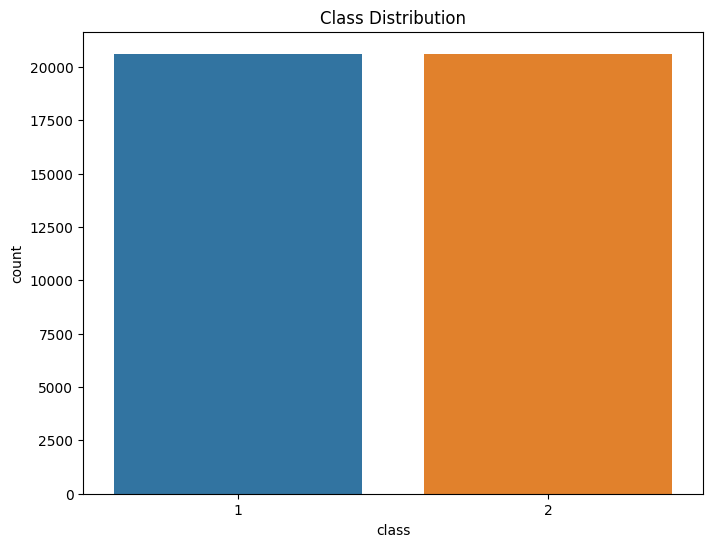

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(df_resampled, x="class")
plt.title("Class Distribution")
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df_resampled['text'], df_resampled['class'], test_size=0.2, random_state=42, stratify=df_resampled['class'])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training class distribution:", Counter(y_train))
print("Validation class distribution:", Counter(y_val))
print("Test class distribution:", Counter(y_test))

train_df = pd.DataFrame({'text': X_train, 'class': y_train})
val_df = pd.DataFrame({'text': X_val, 'class': y_val})
test_df = pd.DataFrame({'text': X_test, 'class': y_test})

print("\nTraining Data:\n", train_df)
print("\nValidation Data:\n", val_df)
print("\nTest Data:\n", test_df)

Training class distribution: Counter({1: 16496, 2: 16496})
Validation class distribution: Counter({2: 2062, 1: 2062})
Test class distribution: Counter({1: 2062, 2: 2062})

Training Data:
                                                     text  class
2489                     @Ashlynohma wtf I DMd you bitch      1
15373  RT @GottaLuvLexci_: You know these hoes wishy ...      1
4406   @PerezHilton \the whole bunch of the trash nee...      1
2419   @AlysiaRianH @cambreezy_ don't call my buddy C...      1
32970  A homeless dog living in a trash pile gets res...      2
...                                                  ...    ...
741                                 #NP "Centuries" ~FOB      2
1214   &#8220;@Damn_ImTall: Anybody that gets traded ...      1
5119   @WalkerJensen yaaaasssss it is. You are buhlow...      1
41014  @1SonofYahweh &amp; what we do with our foolis...      2
28165  Un pollito cruzaba la frontera, un zorro se tr...      2

[32992 rows x 2 columns]

Validation Data:


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix



In [18]:
# Créez un objet TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True)

# Calculez les poids TF-IDF pour chaque terme dans vos données d'entraînement et de test
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["text"])
# Créez un modèle de classification (par exemple, une régression logistique)
classifier = LogisticRegression()

# Entraînez le modèle sur les données d'entraînement et les étiquettes correspondantes
classifier.fit(X_train_tfidf, train_df['class'])

# Prédisez les étiquettes pour les données de test
predictions = classifier.predict(X_test_tfidf)

# Évaluez les performances du modèle en utilisant l'exactitude
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9541707080504365


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Créer un pipeline avec le TfidfVectorizer et le modèle de classification
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2),(2,2)],  # Utiliser des unigrammes, des bigrammes ou les deux
    'clf__C': [0.1, 1, 10],  # Paramètre de régularisation pour la régression logistique
}

# Créer un objet GridSearchCV pour effectuer la recherche sur grille
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

# Entraîner le GridSearchCV sur les données d'entraînement
grid_search.fit(train_df["text"], train_df['class'])

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres:", grid_search.best_params_)

# Prédire les étiquettes pour les données de test en utilisant le meilleur modèle trouvé par GridSearchCV


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Meilleurs paramètres: {'clf__C': 10, 'tfidf__ngram_range': (1, 2)}


In [22]:
predictions = grid_search.predict(val_df["text"])
# Évaluer les performances du modèle en utilisant l'exactitude
acc_tdif_GridSearch = accuracy_score(y_val, predictions)
prec_tdif_GridSearch = precision_score(y_val, predictions, pos_label=True)
rec_tdif_GridSearch = recall_score(y_val, predictions, pos_label=True)
f1_tdif_GridSearch = f1_score(y_val, predictions, pos_label=True)
print('Accuracy:', acc_tdif_GridSearch)
print('Precision:', prec_tdif_GridSearch)r
print('Recall:', rec_tdif_GridSearch)
print('F1 score:', f1_tdif_GridSearch)

Accuracy: 0.9825412221144519
Precision: 0.9989969909729187
Recall: 0.9660523763336566
F1 score: 0.9822485207100591


In [23]:
predictions = grid_search.predict(test_df["text"])
# Évaluer les performances du modèle en utilisant l'exactitude
acc_tdif_GridSearch = accuracy_score(y_test, predictions)
prec_tdif_GridSearch = precision_score(y_test, predictions, pos_label=True)
rec_tdif_GridSearch = recall_score(y_test, predictions, pos_label=True)
f1_tdif_GridSearch = f1_score(y_test, predictions, pos_label=True)
print('Accuracy:', acc_tdif_GridSearch)
print('Precision:', prec_tdif_GridSearch)
print('Recall:', rec_tdif_GridSearch)
print('F1 score:', f1_tdif_GridSearch)

Accuracy: 0.9742967992240543
Precision: 0.9994892747701737
Recall: 0.949078564500485
F1 score: 0.9736318407960199
